In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
import typing as tp
import re
import matplotlib.pyplot as plt

In [3]:
# https://webpages.uidaho.edu/ui-prmd/

base_data_dir: str = os.path.join('..', 'data', 'SemesterProject')

for parent_dir, folders, files in os.walk(base_data_dir):
    print('\n'.join(files))

Animation.m


m09_s04_positions.txt
m08_s02_positions.txt
m05_s01_positions.txt
m09_s01_positions.txt
m03_s02_positions.txt
m05_s06_positions.txt
m07_s03_positions.txt
m07_s08_positions.txt
m02_s09_positions.txt
m09_s09_positions.txt
m08_s10_positions.txt
m08_s08_positions.txt
m09_s05_positions.txt
m02_s01_positions.txt
m03_s01_positions.txt
m07_s01_positions.txt
m06_s02_positions.txt
m05_s03_positions.txt
m06_s10_positions.txt
m01_s01_positions.txt
m02_s03_positions.txt
m02_s06_positions.txt
m01_s06_positions.txt
m06_s03_positions.txt
m06_s06_positions.txt
m02_s10_positions.txt
m09_s03_positions.txt
m04_s03_positions.txt
m08_s05_positions.txt
m04_s08_positions.txt
m01_s09_positions.txt
m04_s07_positions.txt
m10_s04_positions.txt
m05_s08_positions.txt
m08_s03_positions.txt
m07_s05_positions.txt
m08_s07_positions.txt
m09_s07_positions.txt
m07_s07_positions.txt
m08_s04_positions.txt
m07_s02_positions.txt
m06_s01_positions.txt
m01_s07_positions.txt
m05_s05_positions.txt
m10_s03_positions.

## Constructing Training dataset

In [37]:
def rotate_z(t: np.ndarray) -> np.ndarray:
    # Rotation about Z axis
    ct: np.ndarray = np.cos(t)
    st: np.ndarray = np.sin(t)
    return np.array([[ct, -st, 0], [st, ct, 0], [0, 0, 1]])

def rotate_x(t: np.ndarray) -> np.ndarray:
    ct: np.ndarray = np.cos(t)
    st: np.ndarray = np.sin(t)
    return np.array([[1, 0, 0], [0, ct, -st], [0, st, ct]])

def rotate_y(t: np.ndarray) -> np.ndarray:
    ct: np.ndarray = np.cos(t)
    st: np.ndarray = np.sin(t)
    return np.array([[ct, 0, st], [0, 1, 0], [-st, 0, ct]])

def eulers_2_rot_matrix(x: np.ndarray) -> np.ndarray:
    # EULER_2_ROT_MATRIX transforms a set of euler angles into a rotation  matrix
    # This might need a couple of 0's attached to it.
    gamma_x: np.ndarray = x[0]
    beta_y: np.ndarray = x[1]
    alpha_z: np.ndarray = x[2]

    return rotate_z(alpha_z) @ rotate_y(beta_y) @ rotate_x(gamma_x)

def movement_name(movement_id: int) -> str:
    # From the original paper (Table 1):
    # https://webpages.uidaho.edu/ui-prmd/Vakanski%20et%20al%20(2018)%20-%20A%20data%20set%20of%20human%20body%20movements%20for%20physical%20rehabilitation%20exercises.pdf
    match movement_id:
        case 1:
            return 'deep_squat'
        case 2:
            return 'hurdle_step'
        case 3:
            return 'inline_lunge'
        case 4:
            return 'side_lunge'
        case 5:
            return 'sit_to_stand'
        case 6:
            return 'standing_active_straight_leg_raise'
        case 7:
            return 'standing_shoulder_abduction'
        case 8:
            return 'standing_shoulder_extension'
        case 9:
            return 'standing_shoulder_internal-external_rotation'
        case 10:
            return 'standing_shoulder_scaption'
        case _:
            return 'ERROR'


def rotate_joint(curr_joint: np.ndarray, prev_joint_angle: np.ndarray, prev_joint_position: np.ndarray) -> np.ndarray:
    rotate_current_joint: np.ndarray = eulers_2_rot_matrix(prev_joint_angle)

    return (rotate_current_joint @ curr_joint.T).T + prev_joint_position[np.newaxis, :]


def smooth(a: np.ndarray, window_size: int):
    # a: NumPy 1-D array containing the data to be smoothed
    # WSZ: smoothing window size needs, which must be odd number,
    # as in the original MATLAB implementation
    out0 = np.convolve(a,np.ones(window_size,dtype=int),'valid')/window_size
    r = np.arange(1,window_size-1,2)
    start = np.cumsum(a[:window_size-1])[::2]/r
    stop = (np.cumsum(a[:-window_size:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))

In [42]:
# I think I'm gonna work with the Kinect since that one is one I can get a hold of if I need to.

# Going based on animation.m from the source.

kinect_pos_base_dir: str = os.path.join(base_data_dir, 'Segmented Movements', 'Kinect', 'Positions')
kinect_ang_base_dir: str = os.path.join(base_data_dir, 'Segmented Movements', 'Kinect', 'Angles')

parser_pattern: re.Pattern = re.compile(r'm(?P<movement>\d{2})_s(?P<subject>\d{2})_e(?P<episode>\d{2}).*s\.txt')

correct_movements: tp.List[tp.Dict[str, tp.Union[np.ndarray, int]]] = []

"""
    % 1 Waist (absolute)
% 2 Spine
% 3 Chest
% 4 Neck
% 5 Head
% 6 Head tip
% 7 Left collar
% 8 Left upper arm
% 9 Left forearm
% 10 Left hand
% 11 Right collar
% 12 Right upper arm
% 13 Right forearm
% 14 Right hand
% 15 Left upper leg
% 16 Left lower leg
% 17 Left foot
% 18 Left leg toes
% 19 Right upper leg
% 20 Right lower leg
% 21 Right foot
% 22 Right leg toes
    """

joint_connections: np.ndarray = np.array([[4, 6, 5, 3, 2, 3, 7, 8, 9, 3, 11,  12, 13, 1,  15, 16, 17, 1,  19, 20, 21], [3, 5, 3, 2, 1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]])

for fp in os.listdir(kinect_pos_base_dir):
    parsed_match: re.Match = parser_pattern.match(fp)
    movement_id: int = int(parsed_match['movement'])
    subject_id: int = int(parsed_match['subject'])
    episode_num: int = int(parsed_match['episode'])

    print(f'Currently processing movement id {movement_id} / subject id {subject_id} / episode num {episode_num}')

    pos_path: str = os.path.join(kinect_pos_base_dir, f'm{movement_id:02}_s{subject_id:02}_e{episode_num:02}_positions.txt')
    ang_path: str = os.path.join(kinect_ang_base_dir, f'm{movement_id:02}_s{subject_id:02}_e{episode_num:02}_angles.txt')

    if not os.path.exists(pos_path) or not os.path.exists(ang_path):
        continue

    pos_array: np.ndarray = np.loadtxt(pos_path, delimiter=',')
    ang_array: np.ndarray = np.loadtxt(ang_path, delimiter=',')

    for i in range(pos_array.shape[1]):
        pos_array[:, i] = smooth(pos_array[:, i], 5)
        ang_array[:, i] = smooth(ang_array[:, i], 21)

    n_frames: int = pos_array.shape[0]

    skeleton_pos: np.ndarray = np.zeros((22, 3, n_frames))
    skeleton_ang: np.ndarray = np.zeros((22, 3, n_frames))
    pos_array1: np.ndarray = pos_array.T
    ang_array1: np.ndarray = ang_array.T

    for i in range(n_frames):
        skeleton_pos[:, :, i] = pos_array1[:, i].reshape((3, 22)).T
        skeleton_ang[:, :, i] = ang_array1[:, i].reshape((3, 22)).T

    skeleton: np.ndarray = np.zeros((22, 3, n_frames))

    for i in range(n_frames):
        joint: np.ndarray = skeleton_pos[:, :, i]
        joint_angle: np.ndarray = np.deg2rad(skeleton_ang[:, :, i])

        # chest, neck, head
        rot_2 = eulers_2_rot_matrix(joint_angle[0,:])
        joint[1,:] =  (rot_2 @ joint[1,:].T).T + joint[0,:] 
        rot_3 = rot_2 @ eulers_2_rot_matrix(joint_angle[1,:])
        joint[2,:] =  (rot_3 @ joint[2,:].T).T +  joint[1,:]
        rot_4 = rot_3 @ eulers_2_rot_matrix(joint_angle[2,:])
        joint[3,:] =  (rot_4 @ joint[3,:].T).T +  joint[2,:]
        rot_5 = rot_4 @ eulers_2_rot_matrix(joint_angle[3,:])
        joint[4,:] =  (rot_5 @ joint[4,:].T).T +  joint[3,:]
        rot_6 = rot_5 @ eulers_2_rot_matrix(joint_angle[4,:])
        joint[5,:] =  (rot_6 @ joint[5,:].T).T +  joint[4,:]

        # left arm
        rot_7 = eulers_2_rot_matrix(joint_angle[2,:])
        joint[6,:] =  (rot_7 @ joint[6,:].T).T +  joint[2,:]
        rot_8 = rot_7 @ eulers_2_rot_matrix(joint_angle[6,:] )
        joint[7, :] =  (rot_8 @ joint[7, :].T).T +  joint[6, :]
        rot_9 = rot_8 @ eulers_2_rot_matrix(joint_angle[7, :] )
        joint[8, :] =  (rot_9 @ joint[8, :].T).T +  joint[7, :]
        rot_10 = rot_9 @ eulers_2_rot_matrix(joint_angle[8, :])
        joint[9, :] = (rot_10 @ joint[9, :].T).T +  joint[8, :]

        # right arm
        rot_11 = eulers_2_rot_matrix(joint_angle[2, :])
        joint[10, :] =  (rot_11 @ joint[10, :].T).T +  joint[2, :]
        rot_12 = rot_11 @ eulers_2_rot_matrix(joint_angle[10, :])
        joint[11, :] =  (rot_12 @ joint[11, :].T).T +  joint[10, :]
        rot_13 = rot_12 @ eulers_2_rot_matrix(joint_angle[11, :])
        joint[12, :] =  (rot_13 @ joint[12, :].T).T +  joint[11, :]
        rot_14 = rot_13 @ eulers_2_rot_matrix(joint_angle[12, :])
        joint[13, :] =  (rot_14 @ joint[13, :].T).T +  joint[12, :]

        # left leg
        rot_15 = eulers_2_rot_matrix(joint_angle[0, :] )
        joint[14, :] =  (rot_15 @ joint[14, :].T).T +  joint[0, :]
        rot_16 = rot_15 @ eulers_2_rot_matrix(joint_angle[14, :])
        joint[15, :] =  (rot_16 @ joint[15, :].T).T +  joint[14, :]
        rot_17 = rot_16 @ eulers_2_rot_matrix(joint_angle[15, :])
        joint[16, :] =  (rot_17 @ joint[16, :].T).T +  joint[15, :]
        rot_18 = rot_17 @ eulers_2_rot_matrix(joint_angle[16, :])
        joint[17, :] =  (rot_18 @ joint[17, :].T).T +  joint[16, :]

        # right leg
        rot_19 = eulers_2_rot_matrix(joint_angle[0, :])
        joint[18, :] =  (rot_19 @ joint[18, :].T).T +  joint[0, :]
        rot_20 = rot_19 @ eulers_2_rot_matrix(joint_angle[18, :])
        joint[19, :] =  (rot_20 @ joint[19,:].T).T +  joint[18, :]
        rot_21 = rot_20 @ eulers_2_rot_matrix(joint_angle[19, :])
        joint[20, :] =  (rot_21 @ joint[20, :].T).T +  joint[19, :]
        rot_22 = rot_21 @ eulers_2_rot_matrix(joint_angle[20, :])
        joint[21, :] =  (rot_22 @ joint[21, :].T).T +  joint[20, :]
        
        skeleton[:, :, i] = joint

    correct_movements.append({'movement_id': movement_id, 'subject_id': subject_id, 'episode_num': episode_num, 'positions': pos_array, 'angles': ang_array, 'positions_path': pos_path, 'angles_path': ang_path, 'skeleton': skeleton})

df: pd.DataFrame = pd.DataFrame.from_records(correct_movements)

df['movement_name'] = df['movement_id'].map(movement_name)
df['reshaped_skeleton'] = df['skeleton'].apply(lambda s: s.reshape((-1, 22, 3)))

df

Currently processing movement id 4 / subject id 6 / episode num 3
Currently processing movement id 5 / subject id 7 / episode num 8
Currently processing movement id 3 / subject id 1 / episode num 7
Currently processing movement id 3 / subject id 2 / episode num 8
Currently processing movement id 1 / subject id 2 / episode num 4
Currently processing movement id 7 / subject id 5 / episode num 1
Currently processing movement id 6 / subject id 7 / episode num 2
Currently processing movement id 2 / subject id 1 / episode num 6
Currently processing movement id 5 / subject id 10 / episode num 6
Currently processing movement id 1 / subject id 10 / episode num 9
Currently processing movement id 8 / subject id 5 / episode num 7
Currently processing movement id 2 / subject id 10 / episode num 1
Currently processing movement id 1 / subject id 2 / episode num 2
Currently processing movement id 6 / subject id 2 / episode num 3
Currently processing movement id 2 / subject id 8 / episode num 3
Current

,movement_id,subject_id,episode_num,positions,angles,positions_path,angles_path,skeleton,movement_name,reshaped_skeleton
0,4,6,3,"[[-3.02874, 75.90507, -270.5936, 0.0, 27.79706...","[[0.14469, 0.65008, -0.55925, 2.28859, 1.14512...",../data/SemesterProject/Segmented Movements/Ki...,../data/SemesterProject/Segmented Movements/Ki...,"[[[-3.02874, -3.0521766666666665, -3.233198000...",side_lunge,"[[[-3.02874, -3.0521766666666665, -3.233198000..."
1,5,7,8,"[[-1.38662, 84.46687, -232.60986, 0.0, 28.7417...","[[1.29924, -0.9601, -1.45577, 1.84614, 0.07701...",../data/SemesterProject/Segmented Movements/Ki...,../data/SemesterProject/Segmented Movements/Ki...,"[[[-1.38662, -1.3767133333333332, -1.343484, -...",sit_to_stand,"[[[-1.38662, -1.3767133333333332, -1.343484], ..."
2,3,1,7,"[[-12.26233, 81.59789, -248.86124, -2e-05, 27....","[[4.66077, 56.68494, 0.06777, 1.09106, 3.04529...",../data/SemesterProject/Segmented Movements/Ki...,../data/SemesterProject/Segmented Movements/Ki...,"[[[-12.26233, -12.32828, -12.324802, -12.30633...",inline_lunge,"[[[-12.26233, -12.32828, -12.324802], [-12.306..."
3,3,2,8,"[[-32.37641, 83.38937, -259.35818, 0.0, 30.475...","[[6.7506, 30.05265, -0.95628, 1.56654, 5.7209,...",../data/SemesterProject/Segmented Movements/Ki...,../data/SemesterProject/Segmented Movements/Ki...,"[[[-32.37641, -32.4872, -32.529323999999995, -...",inline_lunge,"[[[-32.37641, -32.4872, -32.529323999999995], ..."
4,1,2,4,"[[-5.75375, 91.87819, -256.75516, 0.0, 31.3124...","[[18.99975, 1.46816, -1.66474, 2.46127, -1.360...",../data/SemesterProject/Segmented Movements/Ki...,../data/SemesterProject/Segmented Movements/Ki...,"[[[-5.75375, -5.718733333333334, -5.70244, -5....",deep_squat,"[[[-5.75375, -5.718733333333334, -5.70244], [-..."
...,...,...,...,...,...,...,...,...,...,...
995,3,8,4,"[[17.04467, 71.51766, -242.50504, -1e-05, 30.1...","[[2.46397, -30.05998, 0.82837, 1.3109, -6.5417...",../data/SemesterProject/Segmented Movements/Ki...,../data/SemesterProject/Segmented Movements/Ki...,"[[[17.04467, 17.053053333333335, 17.0540700000...",inline_lunge,"[[[17.04467, 17.053053333333335, 17.0540700000..."
996,5,2,9,"[[-8.55602, 86.74068, -246.46729, 0.0, 32.6057...","[[14.07636, 0.746, -0.30391, 2.17672, -2.15947...",../data/SemesterProject/Segmented Movements/Ki...,../data/SemesterProject/Segmented Movements/Ki...,"[[[-8.55602, -8.558116666666667, -8.550202, -8...",sit_to_stand,"[[[-8.55602, -8.558116666666667, -8.550202], [..."
997,1,6,5,"[[-6.20921, 86.80801, -217.42557, 0.0, 27.6363...","[[2.47181, -3.54129, -2.92796, 2.75055, -0.980...",../data/SemesterProject/Segmented Movements/Ki...,../data/SemesterProject/Segmented Movements/Ki...,"[[[-6.20921, -6.245676666666665, -6.262276, -6...",deep_squat,"[[[-6.20921, -6.245676666666665, -6.262276], [..."
998,10,4,6,"[[-1.20263, 89.59221, -245.85535, -1e-05, 31.5...","[[-0.09863, -4.69102, -0.63648, 1.78622, -0.85...",../data/SemesterProject/Segmented Movements/Ki...,../data/SemesterProject/Segmented Movements/Ki...,"[[[-1.20263, -1.2766499999999998, -1.333304, -...",standing_shoulder_scaption,"[[[-1.20263, -1.2766499999999998, -1.333304], ..."


In [44]:
from scipy.interpolate import interpn

In [87]:
def interp_skeleton(skeleton: np.ndarray, desired_length: int) -> np.ndarray:
    n_joints: int = skeleton.shape[0]
    n_dims: int = skeleton.shape[1]
    orig_n_frames: int = skeleton.shape[2]

    output_skeleton: np.ndarray = np.zeros((n_joints, n_dims, desired_length))

    for joint_i in range(n_joints):
        for dim_j in range(n_dims):
            interpreted_skeleton[joint_i, dim_j, :] = np.interp(np.arange(0, max_len), np.arange(0, n_frames), s[joint_i, dim_j, :])
    return output_skeleton

def fill_skeleton(skeleton: np.ndarray, desired_length: int) -> np.ndarray:
    new_skeleton: np.ndarray = np.zeros((skeleton.shape[0], skeleton.shape[1], desired_length))

    n_repeats: int = desired_length // skeleton.shape[-1]
    num_intermediate_frames: int = n_repeats * skeleton.shape[-1]
    diff_frames: int = desired_length - num_intermediate_frames

    intermediate_array: np.ndarray = np.repeat(skeleton, n_repeats, axis=2)

    new_skeleton[:, :, :num_intermediate_frames] = intermediate_array
    new_skeleton[:, :, num_intermediate_frames:] = skeleton[:, :, :diff_frames]

    return new_skeleton

In [88]:
max_len: int = int(df['skeleton'].apply(lambda s: s.shape[-1]).max())

vals = np.stack(df['skeleton'].apply(lambda s: fill_skeleton(s, max_len)).iloc[:15])

np.max(vals), np.min(vals)

(269.1719374048734, -244.06456344541638)

In [85]:
max_len: int = int(df['skeleton'].apply(lambda s: s.shape[-1]).max())

skeleton: np.ndarray = df['skeleton'].iloc[0]

new_skeleton: np.ndarray = np.zeros((skeleton.shape[0], skeleton.shape[1], max_len))

n_repeats: int = max_len // skeleton.shape[-1]
num_intermediate_frames: int = n_repeats * skeleton.shape[-1]
diff_frames: int = max_len - num_intermediate_frames

intermediate_array: np.ndarray = np.repeat(skeleton, n_repeats, axis=2)

new_skeleton[:, :, :num_intermediate_frames] = intermediate_array
new_skeleton[:, :, num_intermediate_frames:] = skeleton[:, :, :diff_frames]

new_skeleton

array([[[-3.02874000e+00, -3.02874000e+00, -3.05217667e+00, ...,
         -3.03492420e+01, -3.16811460e+01, -3.24396440e+01],
        [ 1.00000000e-05,  1.00000000e-05,  1.00000000e-05, ...,
          1.00000000e-05,  1.00000000e-05,  1.00000000e-05],
        [ 3.31210000e+00,  3.31210000e+00,  3.30571667e+00, ...,
          2.83218800e+00,  2.79866600e+00,  2.76771400e+00]],

       [[ 6.36799193e+01,  6.36799193e+01,  6.36478340e+01, ...,
         -1.10584421e+01, -1.48990951e+01, -1.79956539e+01],
        [ 3.61401941e+01,  3.61401941e+01,  3.61905552e+01, ...,
          5.74998880e+01,  5.69788077e+01,  5.64465368e+01],
        [ 5.64051625e+00,  5.64051625e+00,  5.67070916e+00, ...,
          8.07234269e+00,  8.66251101e+00,  8.65223682e+00]],

       [[-1.72661565e+02, -1.72661565e+02, -1.72557768e+02, ...,
         -1.79313497e+01, -9.69895857e+00, -1.19393851e+00],
        [-9.82590284e+01, -9.82590284e+01, -9.80811374e+01, ...,
         -2.24681029e+02, -2.23867974e+02, -2.225

In [80]:
max_len: int = int(df['skeleton'].apply(lambda s: s.shape[-1]).max())

vals = np.stack(df['skeleton'].apply(lambda s: interp_skeleton(s, max_len)).iloc[1:10])

np.min(vals, axis=3), np.max(vals, axis=3)

(array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
        

In [77]:
vals.shape

(9, 22, 3, 160)

In [71]:
# Probably a good idea to get the same length
# for all of the skeletons as they did here -
# https://github.com/avakanski/A-Deep-Learning-Framework-for-Assessing-Physical-Rehabilitation-Exercises/blob/master/Data/Prepare_Data_for_NN.m



# df['skeleton'].apply(lambda s: )

s: np.ndarray = df['skeleton'].iloc[0]

n_joints, n_dims, n_frames = s.shape

interpreted_skeleton: np.ndarray = np.zeros((n_joints, n_dims, max_len))

for joint_i in range(n_joints):
    for dim_j in range(n_dims):
        poss_new_thing: np.ndarray = np.interp(np.arange(0, max_len), np.arange(0, n_frames), s[joint_i, dim_j, :])
        interpreted_skeleton[joint_i, dim_j, :] = poss_new_thing

interpreted_skeleton.shape

# orig_first_dim: np.ndarray = np.arange(0, s.shape[0])
# orig_second_dim: np.ndarray = np.arange(0, s.shape[1])
# orig_third_dim: np.ndarray = np.arange(0, s.shape[2])
#
# orig_points: tp.Tuple[np.ndarray, np.ndarray, np.ndarray] = (orig_first_dim, orig_second_dim, orig_third_dim)
#
# # orig_mesh1, orig_mesh2, orig_mesh3 = tuple(np.meshgrid(orig_first_dim, orig_second_dim, orig_third_dim, sparse=True))
#
# new_first_dim: np.ndarray = orig_first_dim
# new_second_dim: np.ndarray = orig_second_dim
# new_third_dim: np.ndarray = np.arange(0, max_len)
#
# new_points: tp.Tuple[np.ndarray, np.ndarray, np.ndarray] = new_first_dim, new_second_dim, new_third_dim

# new_mesh1, new_mesh2, new_mesh3 = tuple(np.meshgrid(new_first_dim, new_second_dim, new_third_dim, sparse=True))

# interped_skeleton: np.ndarray = interpn(orig_points, s, new_points, fill_value=None, bounds_error=False)
# new_mesh2.shape, orig_mesh2.shape, new_mesh3.shape, orig_mesh3.shape

# [new_.shape for new_ in new_points], [old.shape for old in orig_points], s.shape

(22, 3, 160)

In [11]:
df['reshaped_skeleton'].apply(lambda s: s.shape)

0     (706, 22, 3)
1     (802, 22, 3)
2     (945, 22, 3)
3     (898, 22, 3)
4     (856, 22, 3)
          ...     
95    (866, 22, 3)
96    (564, 22, 3)
97    (845, 22, 3)
98    (740, 22, 3)
99    (841, 22, 3)
Name: reshaped_skeleton, Length: 100, dtype: object

In [43]:
animate_row: pd.Series = df.query('movement_id == 4').head(1)

skeleton_to_animate: np.ndarray = animate_row['skeleton'].values[0]

np.save(os.path.join('..', 'data', 'SemesterProject', 'skeleton_to_animate'), skeleton_to_animate)

animate_row

,movement_id,subject_id,episode_num,positions,angles,positions_path,angles_path,skeleton,movement_name,reshaped_skeleton
0,4,6,3,"[[-3.02874, 75.90507, -270.5936, 0.0, 27.79706...","[[0.14469, 0.65008, -0.55925, 2.28859, 1.14512...",../data/SemesterProject/Segmented Movements/Ki...,../data/SemesterProject/Segmented Movements/Ki...,"[[[-3.02874, -3.0521766666666665, -3.233198000...",side_lunge,"[[[-3.02874, -3.0521766666666665, -3.233198000..."


In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

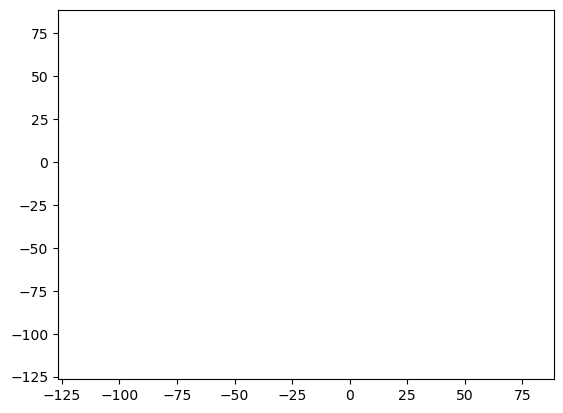

In [15]:
fig, ax = plt.subplots()

curr_plot = ax.plot([], [], 'r.')

max_x: float = np.max(skeleton_to_animate[:, :, 2])
min_x: float = np.min(skeleton_to_animate[:, :, 2])

max_y: float = np.max(skeleton_to_animate[:, :, 1])
min_y: float = np.min(skeleton_to_animate[:, :, 1])

def init():
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    return curr_plot

# for i in range(skeleton_to_animate.shape[0]):
def animate(frame_idx: int):
    joint: np.ndarray = skeleton_to_animate[frame_idx]
    n_joints: int = joint.shape[0]
    x: np.ndarray = joint[:, 2]
    y: np.ndarray = joint[:, 1]

    curr_plot.scatter(x, y, 'r.', marker_size=15)

    for joint_idx in range(joint_connections.shape[1]):
        point1: float = joint[joint_connections[0, joint_idx], :]
        point2: float = joint[joint_connections[1, joint_idx], :]

        # line([point1(3),point2(3)], [point1(1),point2(1)], [point1(2),point2(2)], 'LineWidth',2);
        curr_plot.line([point1[2], point2[2]], [point1[0], point2[0]], line_width=2)

animation_obj = FuncAnimation(fig, animate, frames=skeleton_to_animate.shape[0], init_func=init, blit=True)

plt.show()

In [8]:
inc_df: pd.DataFrame = pd.read_pickle(os.path.join('..', 'data', 'SemesterProject', 'processed_data_incorrect.pkl'))
inc_df.head()

,movement_id,subject_id,episode_num,positions,angles,positions_path,angles_path,skeleton,is_correct_movements,movement_name,filled_skeleton,reshaped_skeleton
0,3,1,3,"[[-16.31684, 80.38445, -245.42615, 1e-05, 27.2...","[[2.28613, 66.97871, -1.30133, 0.76055, -0.517...",../data/SemesterProject/Incorrect Segmented Mo...,../data/SemesterProject/Incorrect Segmented Mo...,"[[[-16.31684, -16.369143333333334, -16.401968,...",False,inline_lunge,"[[[-16.31684, -16.31684, -16.369143333333334, ...","[[[-16.31684, -16.31684, -16.369143333333334],..."
1,2,1,3,"[[-6.68788, 84.80946, -232.44347, 0.0, 28.8086...","[[2.6227, 2.62593, 3.4739, 1.68092, -2.15037, ...",../data/SemesterProject/Incorrect Segmented Mo...,../data/SemesterProject/Incorrect Segmented Mo...,"[[[-6.68788, -6.684496666666667, -6.66963, -6....",False,hurdle_step,"[[[-6.68788, -6.68788, -6.684496666666667, -6....","[[[-6.68788, -6.68788, -6.684496666666667], [-..."
2,7,8,2,"[[-3.23244, 80.24289, -251.78928, -1e-05, 30.9...","[[-1.28387, -7.48507, -3.58032, 1.62932, -0.41...",../data/SemesterProject/Incorrect Segmented Mo...,../data/SemesterProject/Incorrect Segmented Mo...,"[[[-3.23244, -3.235433333333333, -3.2472019999...",False,standing_shoulder_abduction,"[[[-3.23244, -3.23244, -3.23244, -3.2354333333...","[[[-3.23244, -3.23244, -3.23244], [-3.23543333..."
3,4,1,6,"[[-25.22355, 78.29432, -239.78406, 0.0, 28.045...","[[0.46635, 1.28479, 0.33224, 2.03351, -1.67309...",../data/SemesterProject/Incorrect Segmented Mo...,../data/SemesterProject/Incorrect Segmented Mo...,"[[[-25.22355, -25.223069999999996, -25.22245, ...",False,side_lunge,"[[[-25.22355, -25.223069999999996, -25.22245, ...","[[[-25.22355, -25.223069999999996, -25.22245],..."
4,10,1,8,"[[-9.46342, 79.62926, -244.7471, 0.0, 29.45673...","[[-1.45373, 2.39569, -4.59518, 1.90626, 0.6989...",../data/SemesterProject/Incorrect Segmented Mo...,../data/SemesterProject/Incorrect Segmented Mo...,"[[[-9.46342, -9.501323333333334, -9.516294, -9...",False,standing_shoulder_scaption,"[[[-9.46342, -9.46342, -9.501323333333334, -9....","[[[-9.46342, -9.46342, -9.501323333333334], [-..."


In [9]:
inc_df['filled_skeleton'].iloc[0].shape

(22, 3, 180)

In [10]:
corr_df: pd.DataFrame = pd.read_pickle(os.path.join('..', 'data', 'SemesterProject', 'processed_data.pkl'))
corr_df.head()

,movement_id,subject_id,episode_num,positions,angles,positions_path,angles_path,skeleton,is_correct_movements,movement_name,filled_skeleton,reshaped_skeleton
0,4,6,3,"[[-3.02874, 75.90507, -270.5936, 0.0, 27.79706...","[[0.14469, 0.65008, -0.55925, 2.28859, 1.14512...",../data/SemesterProject/Segmented Movements/Ki...,../data/SemesterProject/Segmented Movements/Ki...,"[[[-3.02874, -3.0521766666666665, -3.233198000...",True,side_lunge,"[[[-3.02874, -3.02874, -3.0521766666666665, -3...","[[[-3.02874, -3.02874, -3.0521766666666665], [..."
1,5,7,8,"[[-1.38662, 84.46687, -232.60986, 0.0, 28.7417...","[[1.29924, -0.9601, -1.45577, 1.84614, 0.07701...",../data/SemesterProject/Segmented Movements/Ki...,../data/SemesterProject/Segmented Movements/Ki...,"[[[-1.38662, -1.3767133333333332, -1.343484, -...",True,sit_to_stand,"[[[-1.38662, -1.3767133333333332, -1.343484, -...","[[[-1.38662, -1.3767133333333332, -1.343484], ..."
2,3,1,7,"[[-12.26233, 81.59789, -248.86124, -2e-05, 27....","[[4.66077, 56.68494, 0.06777, 1.09106, 3.04529...",../data/SemesterProject/Segmented Movements/Ki...,../data/SemesterProject/Segmented Movements/Ki...,"[[[-12.26233, -12.32828, -12.324802, -12.30633...",True,inline_lunge,"[[[-12.26233, -12.26233, -12.32828, -12.32828,...","[[[-12.26233, -12.26233, -12.32828], [-12.3282..."
3,3,2,8,"[[-32.37641, 83.38937, -259.35818, 0.0, 30.475...","[[6.7506, 30.05265, -0.95628, 1.56654, 5.7209,...",../data/SemesterProject/Segmented Movements/Ki...,../data/SemesterProject/Segmented Movements/Ki...,"[[[-32.37641, -32.4872, -32.529323999999995, -...",True,inline_lunge,"[[[-32.37641, -32.37641, -32.4872, -32.4872, -...","[[[-32.37641, -32.37641, -32.4872], [-32.4872,..."
4,1,2,4,"[[-5.75375, 91.87819, -256.75516, 0.0, 31.3124...","[[18.99975, 1.46816, -1.66474, 2.46127, -1.360...",../data/SemesterProject/Segmented Movements/Ki...,../data/SemesterProject/Segmented Movements/Ki...,"[[[-5.75375, -5.718733333333334, -5.70244, -5....",True,deep_squat,"[[[-5.75375, -5.75375, -5.718733333333334, -5....","[[[-5.75375, -5.75375, -5.718733333333334], [-..."


In [11]:
corr_df['filled_skeleton'].iloc[0].shape

(22, 3, 180)